<a href="https://colab.research.google.com/github/Mahdi-Golizadeh/GenerativeAdversarialNetwork/blob/main/Simple_GAN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple Generative Adversarial Network with PyTorch

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
torch.__version__

'2.0.0+cu118'

Util function to plot the output images

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = torchvision.utils.make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Generator Network

In [ ]:
def gen_block(input_dim, output_dim):
    return torch.nn.Sequential(
        torch.nn.Linear(input_dim, output_dim),
        torch.nn.BatchNorm1d(output_dim),
        torch.nn.ReLU(inplace= True),
    )

In [ ]:
class Generator(torch.nn.Module):
    '''
    Generator Class
    Values:
        noise_dim: the dimension of the noise vector, a scalar
        image_dim: the dimension of the images, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, noise_dim= 10, image_dim= 784, hidden_dim= 128):
        super(Generator, self).__init__()
        self.gen = torch.nn.Sequential(
            gen_block(noise_dim, hidden_dim),
            gen_block(hidden_dim, hidden_dim * 2),
            gen_block(hidden_dim * 2, hidden_dim * 4),
            gen_block(hidden_dim * 4, hidden_dim * 8),
            torch.nn.Linear(hidden_dim * 8, image_dim),
            torch.nn.Sigmoid()
        )
    
    def forward(self, noise):
        return self.gen(noise)

Discriminator Network

In [ ]:
def disc_block(input_dim, output_dim):
    return torch.nn.Sequential(
        torch.nn.Linear(input_dim, output_dim),
        torch.nn.LeakyReLU(.2, inplace= True)
    )

In [ ]:
class Discriminator(torch.nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, image_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = torch.nn.Sequential(
            disc_block(image_dim, hidden_dim * 4),
            disc_block(hidden_dim * 4, hidden_dim * 2),
            disc_block(hidden_dim * 2, hidden_dim),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (image_dim)
        '''
        return self.disc(image)

Losses and Hyperparameters

In [ ]:
# Set your parameters
criterion = torch.nn.BCEWithLogitsLoss()
# n_epochs = 1
noise_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

# Load MNIST dataset as tensors
dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('.', download=True, 
                               transform=torchvision.transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

### DO NOT EDIT ###
device = 'cuda' if torch.cuda.is_available() else "cpu"

100%|██████████| 9912422/9912422 [00:00<00:00, 95665195.36it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 95082962.19it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27276888.42it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16963961.50it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
print(device)

cuda


Initializing Networks

In [ ]:
gen = Generator(noise_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device= device)

In [ ]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    noise = get_noise(num_images, z_dim, device=device)
    gen_i = gen(noise)
    preds = disc(gen_i.detach())
    gen_loss = criterion(preds, torch.zeros_like(preds))
    r_preds = disc(real)
    r_loss = criterion(r_preds, torch.ones_like(r_preds))
    disc_loss = (gen_loss + r_loss)/2
    return disc_loss

In [ ]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    noise = get_noise(num_images, z_dim, device=device)
    gen_i = gen(noise)
    preds = disc(gen_i)
    gen_loss = criterion(preds, torch.ones_like(preds))
    return gen_loss

Training

  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 0 disc_loss is: 1.5578229285310954 and gen_loss is: 4.744237496828039


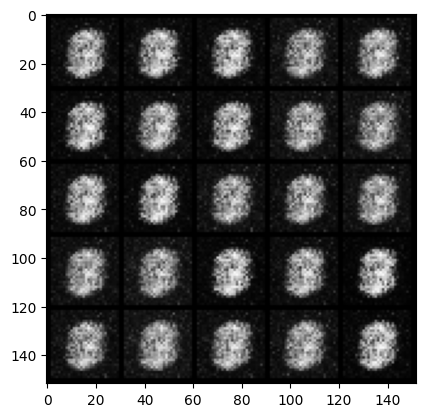

  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 1 disc_loss is: 1.1043735761195421 and gen_loss is: 5.911954312895735


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 2 disc_loss is: 0.6692661899141967 and gen_loss is: 7.129130593811472


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 3 disc_loss is: 0.7857301387703046 and gen_loss is: 6.249426715696852


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 4 disc_loss is: 0.9062771360622719 and gen_loss is: 5.5437851548194885


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 5 disc_loss is: 0.8437766414911797 and gen_loss is: 5.915471143089235


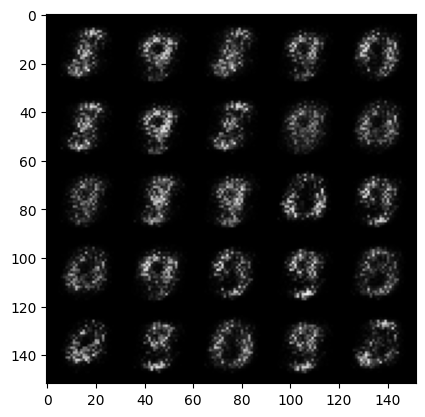

  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 6 disc_loss is: 0.6609280738242281 and gen_loss is: 7.138770057198902


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 7 disc_loss is: 0.46257156880650047 and gen_loss is: 8.701100887730718


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 8 disc_loss is: 0.40410898538539186 and gen_loss is: 10.270333842684826


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 9 disc_loss is: 0.37772041355492547 and gen_loss is: 10.661918580532074


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 10 disc_loss is: 0.327826453052694 and gen_loss is: 11.423197923228145


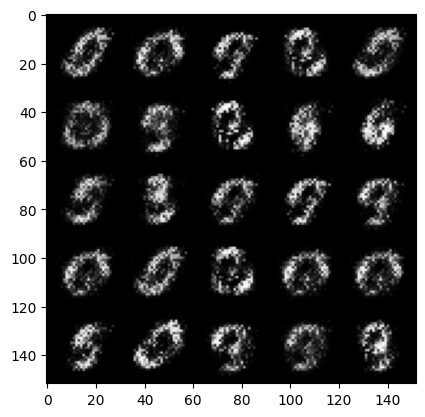

  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 11 disc_loss is: 0.292547598471477 and gen_loss is: 12.379663133372864


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 12 disc_loss is: 0.3303131588327233 and gen_loss is: 12.362399125471711


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 13 disc_loss is: 0.25348957354435697 and gen_loss is: 13.444285045067469


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 14 disc_loss is: 0.23681798685962954 and gen_loss is: 13.677279125278195


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 15 disc_loss is: 0.2561997713443513 and gen_loss is: 13.373868632440766


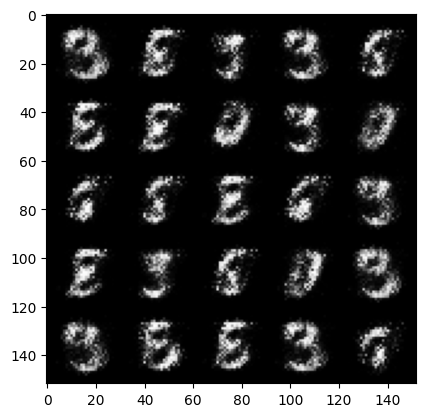

  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 16 disc_loss is: 0.2535438539246873 and gen_loss is: 13.935219943523407


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 17 disc_loss is: 0.2449241655122023 and gen_loss is: 14.072205499435464


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 18 disc_loss is: 0.29879542149137706 and gen_loss is: 14.162855071946979


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 19 disc_loss is: 0.30836732616686885 and gen_loss is: 13.421876509363452


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 20 disc_loss is: 0.2606362420095441 and gen_loss is: 14.094968298450112


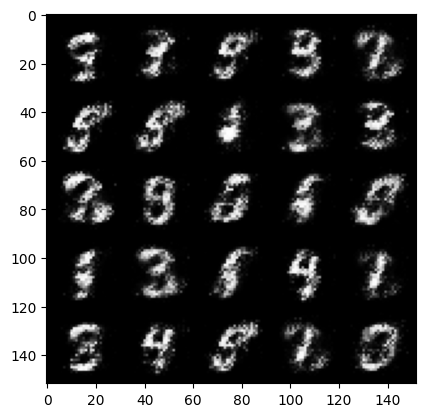

  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 21 disc_loss is: 0.2836992316782319 and gen_loss is: 13.752272309114536


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 22 disc_loss is: 0.3135354261903558 and gen_loss is: 13.73670012007157


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 23 disc_loss is: 0.2983874942098434 and gen_loss is: 13.441804193581143


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 24 disc_loss is: 0.32104331120111357 and gen_loss is: 13.390328261380395


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 25 disc_loss is: 0.3127317145311584 and gen_loss is: 13.39379133284092


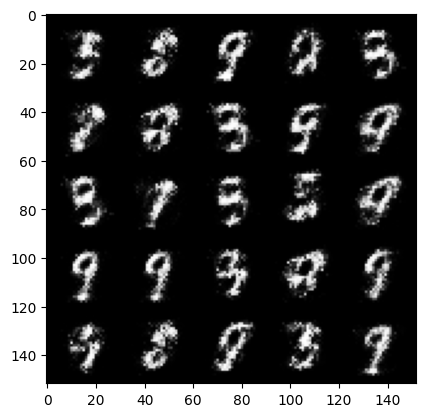

  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 26 disc_loss is: 0.33665546180175926 and gen_loss is: 13.26680371661981


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 27 disc_loss is: 0.4067162489324498 and gen_loss is: 13.139864029362798


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 28 disc_loss is: 0.39143855004416156 and gen_loss is: 13.059060538808504


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 29 disc_loss is: 0.3581913391147585 and gen_loss is: 12.753805783887705


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 30 disc_loss is: 0.4117531528075536 and gen_loss is: 12.446089501182238


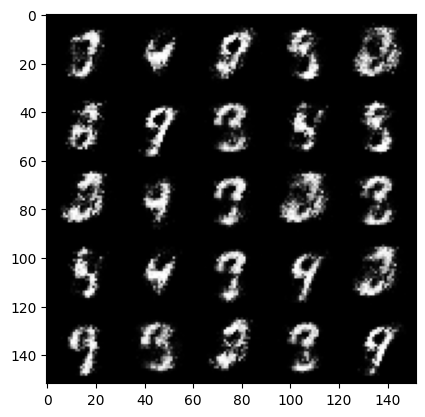

  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 31 disc_loss is: 0.3866972577816341 and gen_loss is: 13.02858461563786


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 32 disc_loss is: 0.3892283375413778 and gen_loss is: 12.882936634744206


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 33 disc_loss is: 0.4079524163971655 and gen_loss is: 12.820708684623241


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 34 disc_loss is: 0.48880961412214674 and gen_loss is: 11.950120510533452


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 35 disc_loss is: 0.43343603224881616 and gen_loss is: 12.514777299016714


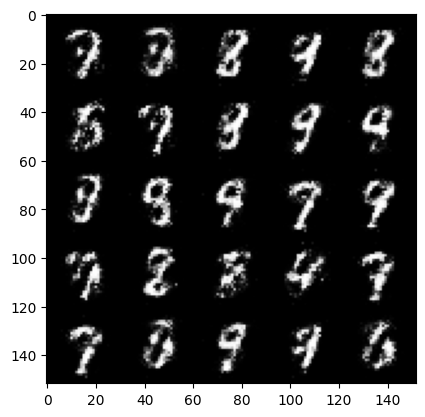

  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 36 disc_loss is: 0.4645859158287446 and gen_loss is: 12.434029738108316


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 37 disc_loss is: 0.541126987314783 and gen_loss is: 11.950687807674209


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 38 disc_loss is: 0.5209908729690748 and gen_loss is: 11.882485972717404


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 39 disc_loss is: 0.5810575267920891 and gen_loss is: 11.773418774207434


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 40 disc_loss is: 0.5031856923014857 and gen_loss is: 11.679539750019709


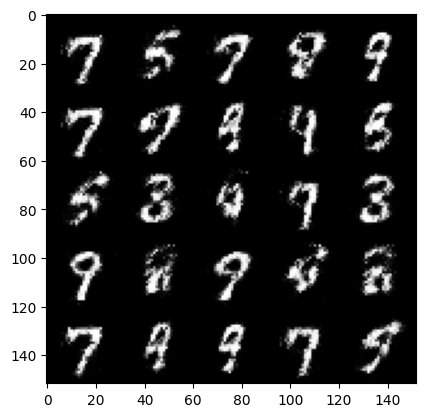

  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 41 disc_loss is: 0.5367640778422356 and gen_loss is: 11.639056272183856


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 42 disc_loss is: 0.6153706808884939 and gen_loss is: 11.423950362329682


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 43 disc_loss is: 0.6249059700251868 and gen_loss is: 10.8190056613336


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 44 disc_loss is: 0.7148140932161672 and gen_loss is: 10.383295789361


  0%|          | 0/469 [00:00<?, ?it/s]

for epoch: 45 disc_loss is: 0.7512925696792081 and gen_loss is: 10.020301160092155


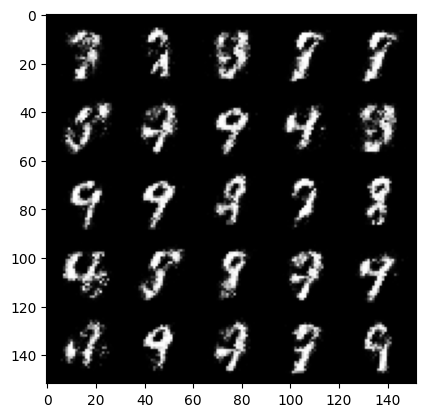

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
n_epochs = 200
generator_loss = []
discriminator_loss = []
for epoch in range(n_epochs):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    for real_image, _ in tqdm(dataloader):
        curr_batch_size = len(real_image)
        real_image = real_image.view(curr_batch_size, -1).to(device) 
        #discriminator training part
        gen.eval()
        disc_opt.zero_grad()
        # discriminator loss calculation
        disc_loss = get_disc_loss(gen, disc, criterion, real_image, curr_batch_size, noise_dim, device)
        #################################
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        mean_discriminator_loss += disc_loss.item() /curr_batch_size
        gen.train()
        #generator training part
        disc.eval()
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, curr_batch_size, noise_dim, device)
        gen_loss.backward()
        gen_opt.step()
        mean_generator_loss += gen_loss.item() / curr_batch_size
        disc.train()
        ##################################
    print(f"for epoch: {epoch} disc_loss is: {mean_discriminator_loss} and gen_loss is: {mean_generator_loss}")
    discriminator_loss.append(mean_discriminator_loss)
    generator_loss.append(mean_generator_loss)
    if epoch % 5 == 0:
        fake_noise = get_noise(curr_batch_size, noise_dim, device=device)
        fake = gen(fake_noise)
        show_tensor_images(fake)